# Week 10 -- Severance Costs and Leading Eigenvalue Utility

This tutorial is for you the extend the model from last week using either your solution or the provided solution. The goal is to add severance costs to the model and to use the leading eigenvalue utility function.


## Section 1: Update the Utility
Adapt the `Agent` class to use the utility function computed as in the slides, i.e., the leading eigenvalue of the utility function. The utility function is given by: 

$$
u_i^* = \lim_{t\to \infty} u_i(t) = \lambda_{PF}(G_{i})- c k_i
$$

For details refer to the slides.

In [166]:
import mesa
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

from mesa import Model
from mesa.agent import Agent
from mesa.datacollection import DataCollector
from visualization_functions import plot_network
from scipy.sparse.linalg import eigs, eigsh



In [167]:
class RandomSingleActivation(mesa.time.BaseScheduler):
    """A scheduler to activate only one random agent per step."""
    def step(self):
        if self.agents:
            agent = random.choice(self.agents)
            agent.step()
            
        self.steps += 1
        self.time += 1

class RandomOrderedSingleActivation(mesa.time.BaseScheduler):
    """
    A scheduler to activate only one random agent per step. The order of agents is shuffled. 
    An agent is activated again only after all other agents have been activated.
    """
    def __init__(self, model: Model, agents = None) -> None:
        super().__init__(model, agents)
        self.agents_copy = self.agents
        self.used_uids = []
        random.seed(42)
        
    def step(self):
        if len(self.used_uids) == len(self.model.agents):
            self.used_uids = []
        if self.agents:
            agent = random.choice(self.agents)
            while agent.uid in self.used_uids: # Inefficient, but struggling with the agents.remove() ...
                agent = random.choice(self.agents)
            self.used_uids.append(agent.uid)
            agent.step()

        self.steps+=1
        self.time+=1

In [168]:
from numpy import real


class Agent(mesa.Agent):
    """
    Agent class for the network formation model.
    """

    def __init__(self, model:"World", unique_id):
        super().__init__(unique_id, model)
    
    # ==== Properties ====
    # implement properties of the agent that are useful for the model, especially with respect to its position in the network
    # some are already provided, but you may need to add more
    
    @property
    def uid(self):
        """unique agent identifier, useful for matching agents to network nodes"""
        return self.unique_id

    def subgraph(self, network = None, copy=False):
        """The graph induced by selecting only the component to which the agent belongs."""
        if network is None:
            my_component = self.component_uids()
            network = self.model.net
        else:
           my_component = self.component_uids(network)

        sub_graph = nx.subgraph(network, my_component)
        if copy:
            return sub_graph.copy()
        return sub_graph
    
    def component_uids(self, network = None):
        """returns the uids of the component in which this agent resides"""
        if network is None:
            network = self.model.net
        my_comp = [c for c in nx.connected_components(network) if self.uid in c][0]
        return my_comp


    # === Basic Actions ===
    # implement the basic actions of the agent

    # === agent decisions ===
    def utility(self, subgraph):
        """
        The utility for the agent given his position in the network."""
        adj = nx.adjacency_matrix(subgraph)
        # val = eigs(adj.toarray(), k=1, which='LM', return_eigenvectors=False)
        val = max(np.linalg.eigvals(adj.toarray()))
        
        degree = nx.degree(subgraph,self.uid)
        util = real(val) - self.model.cost*degree

        return util
    
    def peek_utility(self, action: str, other_node):
        assert action == "add" or action == "remove"

        if action == "add":
            self.model.net.add_edge(self.uid, other_node)
            util = self.utility(self.subgraph())
            self.model.net.remove_edge(self.uid, other_node)

        elif action == "remove":
            self.model.net.remove_edge(self.uid, other_node)
            util = self.utility(self.subgraph())
            self.model.net.add_edge(self.uid, other_node)

        return util
    

    # === Update Rules ===
    def perform_best_action(
        self, mutual_creation=True, mutual_deletion=False, max_sample=None
    ):
        """
        Create/Delete a link or do nothing according to the action that maximizes the agent's utility.
        mutual_creation: bool, whether the agent can create a link with another agent only if the link benefits the second agent as well.
        mutual_deletion: bool, whether the agent can delete a link with another agent only if the link deletion benefits the second agent as well.
        """

        # ! Not too happy with this logic: 

        # Should've made a function that "checks" utility instead of hard coding it here.
        # Unnecessary with 2 loops because all other nodes are either a neighbor or not, so only need to visit each node once and then assign their
        # reward based on whether we are deleting or adding edge, but keeping it all in the same dict. Then checking when performing the best action
        # if we're gonna add or delete an edge to the best other agent.
        
        # First, make a dict with all potential rewards:
        actions_and_rewards = {}
        # First iterate over nodes that are not connected to self and check the utility if we add edge to these
        for node in self.model.net.nodes:
            if node not in self.model.net.neighbors(self.uid) and node != self.uid:

                actions_and_rewards.update({node: self.peek_utility("add", node)})

        neighbors = [n for n in self.model.net.neighbors(self.uid)]
        # Now iterate over neighbors and check utility if we would remove edge to them
        for neighbor in neighbors:
            if neighbor != self.uid:
                prev_util = self.utility(self.subgraph())
                util = self.peek_utility("remove", neighbor)
                delta = util-prev_util
                if delta > 0:
                    util -= (1-self.model.alpha) * delta

                actions_and_rewards.update({neighbor: util})


        # Now sort the reward dictionary to get the highest reward first
        sorted_actions_and_rewards = {k: v for k, v in sorted(actions_and_rewards.items(), key=lambda item: item[1], reverse=True)}
        # If utility is better as is, compared to the highest utility in the possible actions: Do nothing
        if all(value < self.utility(self.subgraph()) for value in sorted_actions_and_rewards.values()):
            return
        # Select the other agent to perform action on
        for key in sorted_actions_and_rewards.keys():
            selected_agent = [k for k in self.model.agents if k.uid == key][0]
            # If the other agent is neighbor, we are gonna delete an edge, although I'm not sure if this ever happens in the simulation ??
            if selected_agent.uid in self.model.net.neighbors(self.uid):
                if not mutual_deletion:
                    
                    self.model.net.remove_edge(self.uid,selected_agent.uid)
                    return
                else: # Have to check that both self and the other agent will have improved utilities to remove the edge
                    prev_util = selected_agent.utility(selected_agent.subgraph())
                    new_util = selected_agent.peek_utility("remove", self.uid)
                    delta = new_util-prev_util
                    if delta > 0:
                        new_util -= (1-self.model.alpha) * delta
                    # self.model.net.remove_edge(self.uid,selected_agent.uid)
                    # new_util = selected_agent.utility(selected_agent.subgraph())
                    if new_util > prev_util: # If it was better before for the other agent, add the edge back 
                        self.model.net.remove_edge(self.uid,selected_agent.uid)
                        return
            else: # The other agent is not a neighbor, so we'll add an edge
                if not mutual_creation:
                    self.model.net.add_edge(self.uid,selected_agent.uid)
                    return
                else:
                    prev_util = selected_agent.utility(selected_agent.subgraph())
                    new_util = selected_agent.peek_utility("add", self.uid)
                    # self.model.net.add_edge(self.uid,selected_agent.uid)
                    # new_util = selected_agent.utility(selected_agent.subgraph())
                    if new_util > prev_util:
                        self.model.net.add_edge(self.uid,selected_agent.uid)
                        return




        

    def step(self):
        max_sample = self.model.max_sample
        mutual_create = self.model.mutual_create
        mutual_delete = self.model.mutual_delete

        # perform the best action available
        self.perform_best_action(mutual_create, mutual_delete, max_sample)

In [169]:
# Model class
class World(mesa.Model):
    """The World class represents the environment in which the Agents interact.

    The class keeps track of the Network on which the agents interact, the alterations to it
    over time as well as the model time
    """

    def __init__(self, num_agents, cost,
                 mutual_create, 
                 mutual_delete,
                 poling_interval=1, 
                 check_stability=None, 
                 max_steps=None,
                 max_sample=None,
                 plot_network=False,
                 schedule=mesa.time.BaseScheduler,
                 alpha=1.0
                 ):
        super().__init__()
        self.schedule = schedule(self)
        self.net = nx.Graph()
        self.max_sample = max_sample
        self.cost = cost
        self._id_counter = 0
        self.poling_interval = poling_interval
        self.check_stability = check_stability
        if not self.check_stability and max_steps:
            self.check_stability = max_steps + 1
        else:
            self.check_stability = 1
        self.mutual_create = mutual_create
        self.mutual_delete = mutual_delete
        self.max_steps = max_steps
        self.num_agents = num_agents
        self.plot = plot_network
        self.alpha = alpha

        self.add_agents(num_agents)

        self.datacollector = DataCollector(
            {
                "welfare": lambda m: m.aggregate_welfare(),
                "density": lambda m: m.density(),
                "clustering": lambda m: m.clustering(),
                "num_components": lambda m: len(list(m.connected_components())),
            }
        )

    # === Basic Actions ===

    def _generate_uid(self):
        """generate a unique uid"""
        valid_id_found = False
        uid = None
        while not valid_id_found:
            uid = self._id_counter
            valid_id_found = uid not in self.net
            self._id_counter += 1
        return uid

    def add_agents(self, num_agents):
        """Add the specified number of agents or ids in agent_list to the World.
        """
        for _ in range(num_agents):
            self.add_agent()

    def add_agent(self):
        """Add a single Agent to the simulation
        """
        uid = self._generate_uid() # generate a unique uid for the agent in the network
        if uid in self.net:
            raise KeyError(f"`uid={uid}` already taken")

        agent = Agent(self, uid)
        self.schedule.add(agent)
        self.net.add_node(uid)

    # === Network properties (for reporting) ===
    def aggregate_welfare(self):
        """Compute aggregated welfare (i.e. the sum of all utilities) of the agents in the network
        """
        welfare = sum(a.utility(a.subgraph()) for a in self.schedule.agents)
        return welfare

    def density(self):
        """Returns the proportion of possible edges which are actually present"""
        return nx.density(self.net)

    def clustering(self):
        """See networkx.average_clustering"""
        return nx.average_clustering(self.net)

    def connected_components(self):
        """Returns a generator containing the uids of the current network

        Yields:
            sets of uids in the same component
        """
        return nx.connected_components(self.net)

    # === Stability Checks (to stop simulation) ===
    def is_pairwise_stable(self, agents=None, mutual_create=True, mutual_delete=True):
        """Return true if no agent would be willing to make a change (either create or delete)

        Args:
            agents (list of Agents): if the stability should only be checked for this subset pass a
                list of agents otherwise the stability is computed considering all agents
            mutual_create (bool): require that neither agent is worse off when creating the link
            mutual_delete (bool): require that neither agent is worse off when deleting the link

        Returns:
            Returns True if no agent wants to make a move, False otherwise
        """
        # short circuit logic to reduce the number of comparisons necessary to find that the
        # system is not stable (i.e. at least one agent wants to make a move).
        # If it is in fact stable all agents need to be tested
        deletion_stable = self.is_deletion_stable(agents, mutual=mutual_delete)

        if deletion_stable is False:  # the first test is False -> all is False
            return False

        # The first test has yielded True if the next test is False -> all is False
        creation_stable = self.is_creation_stable(agents, mutual=mutual_create)
        return creation_stable

    def is_deletion_stable(self, agents=None, mutual=True):
        """Returns True if no Agent would be willing to delete a link"""
        return self._is_simple_action_stable(agents, create=False, mutual=mutual)

    def is_creation_stable(self, agents=None, mutual=True):
        """Returns True if no Agent would be willing to create one more edge"""
        return self._is_simple_action_stable(agents, create=True, mutual=mutual)

    def _is_simple_action_stable(self, agents=None, create=True, mutual=True):
        """Given either create=True or create=False (i.e. delete) the function returns True if no
        Agent would be willing to perform an action of the given type."""
        if agents is None:
            agents = self.schedule.agents

        for agent in agents:
            _, other_agent = agent.best_simple_action(create, mutual)
            if other_agent is not None:
                return False
        return True
    
    def step(self):
        # at given interval report on the state of the system
        if self.schedule.time % self.poling_interval == 0:
            self.datacollector.collect(self)
            if self.plot:
                plot_network(world)
                plt.show()
            
        self.schedule.step()
        check_stability = self.check_stability
        mutual_create = self.mutual_create
        mutual_delete = self.mutual_delete
    

        if self.schedule.time>0 and check_stability and (self.schedule.time % check_stability == 0):
            print(check_stability)
            if self.is_pairwise_stable(
                mutual_create=mutual_create, mutual_delete=mutual_delete
            ):
                self.running = False
        
        if self.max_steps and self.schedule.time >= self.max_steps:
            self.running = False

In [214]:
params = {"num_agents": 50, 
          "cost": 0.2,
          "mutual_create": True,
          "mutual_delete": False,
          "max_steps": 500,
          "plot_network": False,
          "schedule": RandomOrderedSingleActivation}
world = World(**params, alpha=0)

world.run_model()
print("High severance done")


World 1 done


In [215]:
world2 = World(**params, alpha=0.3)
world2.run_model()
print("Medium severance done")

Medium severance done


In [216]:
world3 = World(**params, alpha=1)
world3.run_model()
print("No severance done")

No severance done


# $c=0.2$
### $\alpha_1 = 0$
### $\alpha_2 = 0.3$
### $\alpha_3 = 1$

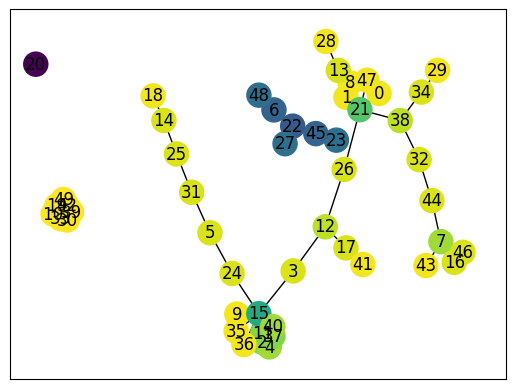

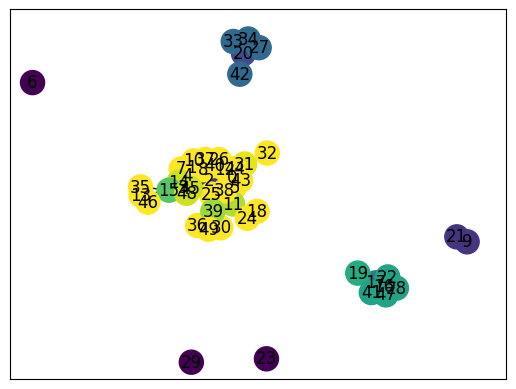

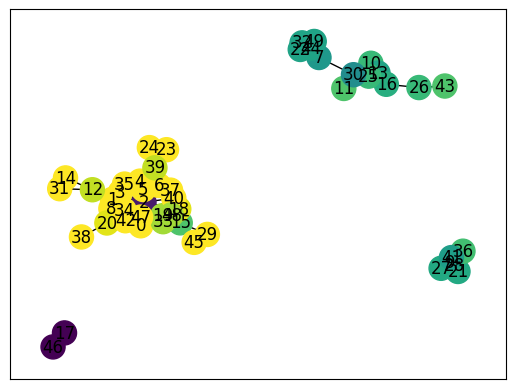

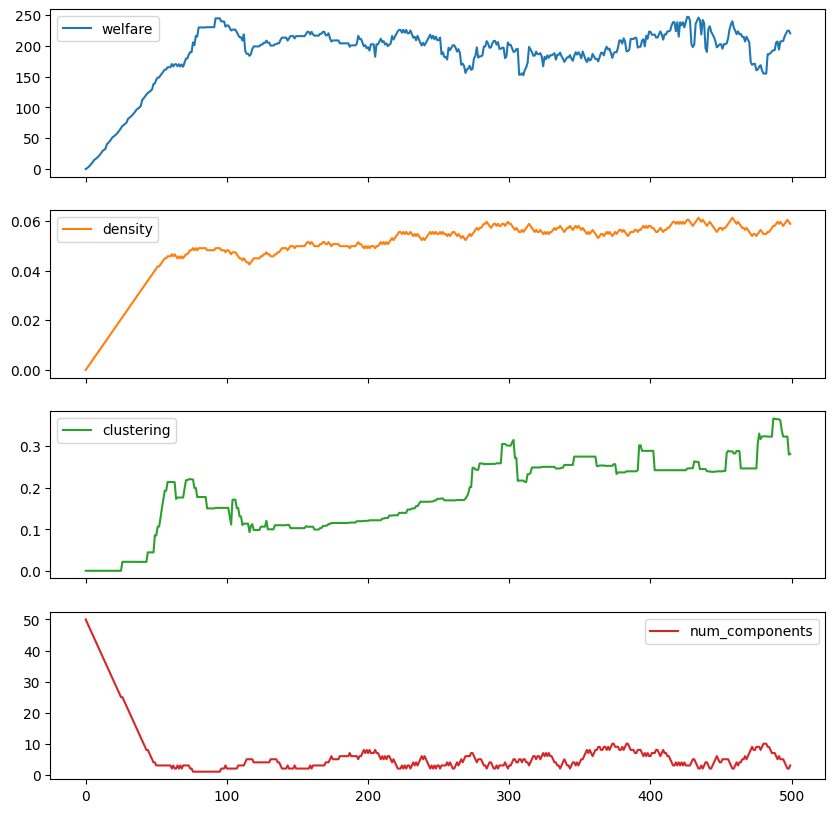

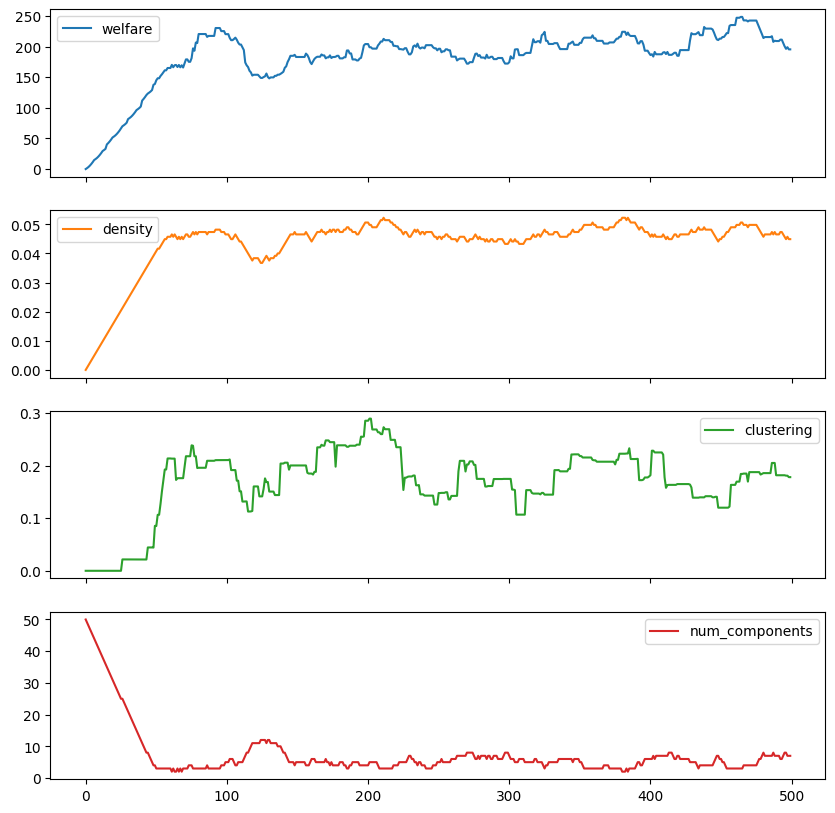

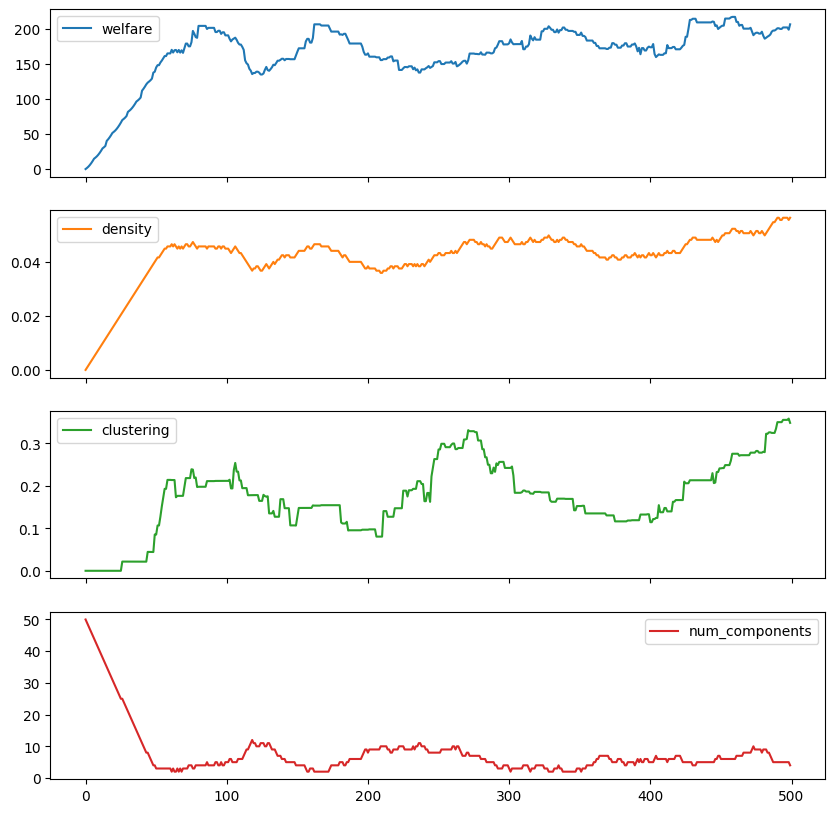

Number of components with alpha= 0 : 3
Number of components with alpha= 0.3 : 7
Number of components with alpha= 1 : 4


In [217]:
plot_network(world)
plt.show()
plot_network(world2)
plt.show()
plot_network(world3)
plt.show()

df = world.datacollector.get_model_vars_dataframe()
df.plot(subplots=True, figsize=(10, 10))
plt.show()
df2 = world2.datacollector.get_model_vars_dataframe()
df2.plot(subplots=True, figsize=(10, 10))
plt.show()
df3 = world3.datacollector.get_model_vars_dataframe()
df3.plot(subplots=True, figsize=(10, 10))
plt.show()

print("Number of components with alpha=",world.alpha,":",world.datacollector.get_model_vars_dataframe()["num_components"].to_numpy()[-1])
print("Number of components with alpha=",world2.alpha,":",world2.datacollector.get_model_vars_dataframe()["num_components"].to_numpy()[-1])
print("Number of components with alpha=",world3.alpha,":",world3.datacollector.get_model_vars_dataframe()["num_components"].to_numpy()[-1])

# Disconnected cliques
Does not correspond with bounds for $n$ from lecture slide (?)

In [236]:
from math import ceil, floor


def disconnected_clique_lower(c):
    return ceil((1+c*(1-c))/c)
def disconnected_clique_upper(c, alpha):
    return floor((2-alpha*c*(1-alpha*c))/(alpha*c))

c=0.5
alpha=0.9
print(disconnected_clique_lower(c), disconnected_clique_upper(c, alpha)) # HMM



3 3


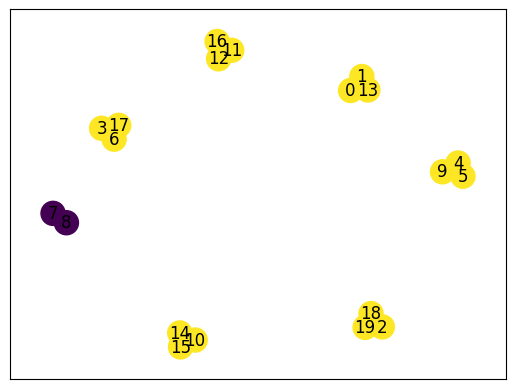

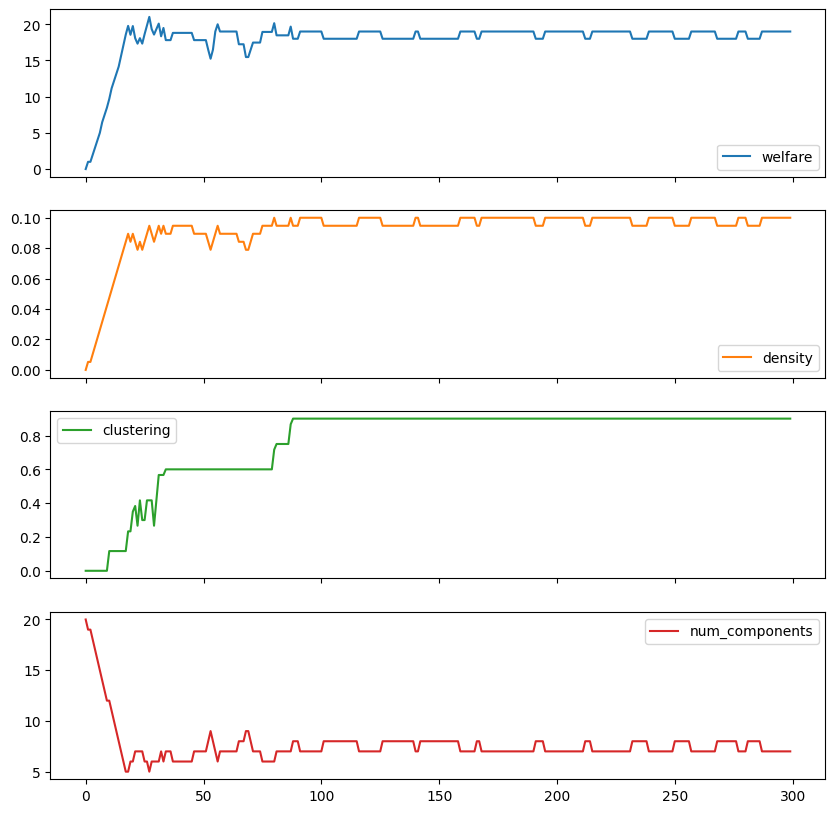

In [237]:
disconnected_cliques_params = {"num_agents": 20, 
          "cost": c,
          "mutual_create": True,
          "mutual_delete": False,
          "max_steps": 300,
          "plot_network": False,
          "schedule": RandomOrderedSingleActivation,
          "alpha": alpha}

disconnected_cliques_model = World(**disconnected_cliques_params)
disconnected_cliques_model.run_model()

plot_network(disconnected_cliques_model)
plt.show()

df = disconnected_cliques_model.datacollector.get_model_vars_dataframe()
df.plot(subplots=True, figsize=(10, 10))
plt.show()

# Spanning star 
:)

In [241]:
def spanning_star_lower(c):
    return ceil(2/c)
def spanning_star_upper(c, alpha):
    return floor((1-alpha**2*c**2*(6-alpha**2*c**2))/(4*alpha**2*c**2))

c_star=0.1
alpha_star=0.5
print(spanning_star_lower(c_star), spanning_star_upper(c_star, alpha_star)) 


20 98


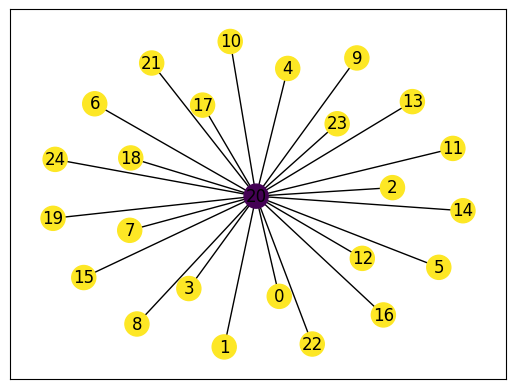

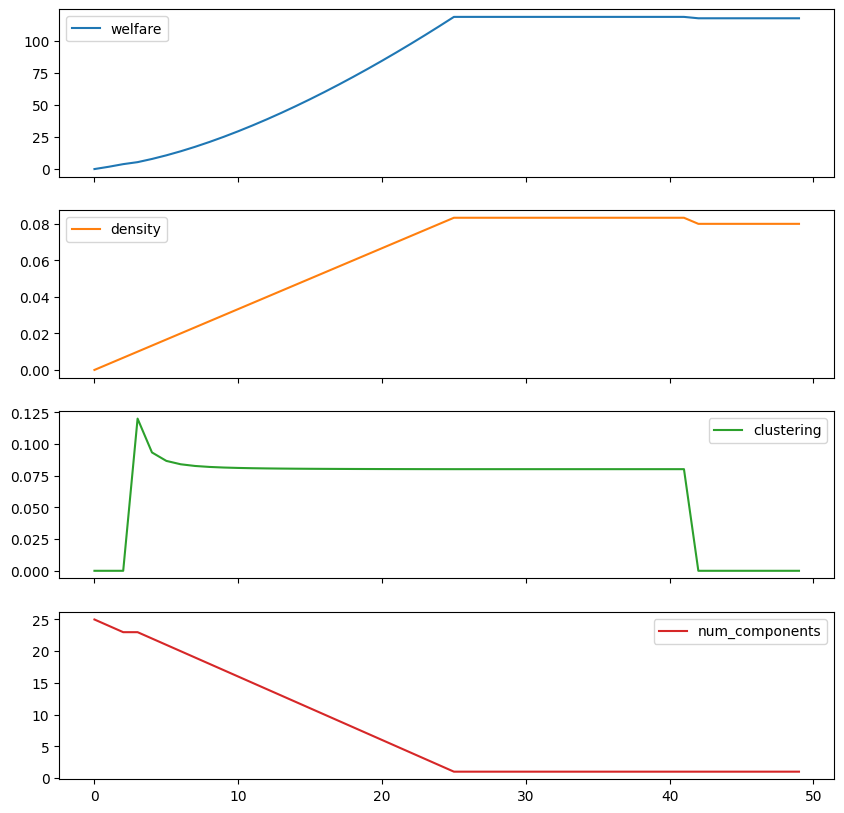

In [243]:
spanning_star_params = {"num_agents": 25, 
          "cost": c_star,
          "mutual_create": True,
          "mutual_delete": False,
          "max_steps": 50,
          "plot_network": False,
          "schedule": RandomOrderedSingleActivation,
          "alpha": alpha_star}

spanning_star_model = World(**spanning_star_params)
spanning_star_model.run_model()

plot_network(spanning_star_model)
plt.show()

df = spanning_star_model.datacollector.get_model_vars_dataframe()
df.plot(subplots=True, figsize=(10, 10))
plt.show()

## Section 2: Add Severance Costs

Add severance costs to the model. Severance costs are paid when an agent decides to cut a link, look at the slides for the details.

## Section 3: Plot results

Plot the graphs for different severance costs and compare them to the results from last week.